In [1]:
import pandas as pd
import os
import numpy as np
import scipy
import math
import random
import sklearn
import nltk
import warnings
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse.linalg import svds
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn import preprocessing
from sklearn.metrics import roc_curve, auc

In [2]:
path="D:/CDS513/Assignment 1/input"
    
os.chdir(path)

# Read csv data file
# Data without feature standardization
df = pd.read_csv('Data_final_description.csv')

In [3]:
df

,User-id,Game-id,Game-title,Genre,personal-rating,description
0,5250,96,Alien Swarm,Shooter,3,Alien Swarm is a game and Source SDK release f...
1,975449,96,Alien Swarm,Shooter,5,Alien Swarm is a game and Source SDK release f...
2,1950243,96,Alien Swarm,Shooter,3,Alien Swarm is a game and Source SDK release f...
3,2259650,96,Alien Swarm,Shooter,2,Alien Swarm is a game and Source SDK release f...
4,2753525,96,Alien Swarm,Shooter,2,Alien Swarm is a game and Source SDK release f...
...,...,...,...,...,...,...
42241,287824954,462,Close Your Eyes,Puzzle,5,Close Your Eyes is a puzzle horror game where ...
42242,293303005,100,All Is Dust,Role-playing (RPG),5,Dust off the vacuum and tidy up with The Sims ...
42243,300248088,2093,Sigils of Elohim,Puzzle,5,"As if awakening from a deep sleep, you find yo..."
42244,306839937,2029,Secret Files Tunguska,Point-and-click,5,Unravel one of the greatest mysteries of our t...


# Finding # of interaction

In [4]:
users_interactions_count_df = df.groupby(['User-id', 'Game-id']).size().groupby('User-id').size()
print('# users: %d' % len(users_interactions_count_df))

users_with_enough_interactions_df = users_interactions_count_df[users_interactions_count_df >= 5]\
                                    .reset_index()[['User-id']]


users_with_few_interactions_df = users_interactions_count_df[users_interactions_count_df < 3]\
                                    .reset_index()[['User-id']]

print('# users with at least 5 interactions: %d' % len(users_with_enough_interactions_df))
print('# users with less than 3 interactions: %d' % len(users_with_few_interactions_df))

# users: 8470
# users with at least 5 interactions: 1717
# users with less than 3 interactions: 5937


In [5]:
interactions_from_selected_users_df = df.merge(users_with_enough_interactions_df, 
               how = 'right',
               left_on = 'User-id',
               right_on = 'User-id')

interactions_from_few_selected_users_df = df.merge(users_with_few_interactions_df, 
               how = 'right',
               left_on = 'User-id',
               right_on = 'User-id')

print('# of interactions from all users: %d' % len(df))
print('# of interactions from users with at least 5 interactions: %d' % len(interactions_from_selected_users_df))
print('# of interactions from users with less than 3 interactions: %d' % len(interactions_from_few_selected_users_df))

# of interactions from all users: 42246
# of interactions from users with at least 5 interactions: 32535
# of interactions from users with less than 3 interactions: 6935


In [6]:
def smooth_user_preference(x):
    return math.log(1+x, 2)
    
interactions_full_df = interactions_from_selected_users_df \
                    .groupby(['User-id', 'Game-id'])['personal-rating'].sum() \
                    .apply(smooth_user_preference).reset_index()
print('# of unique user/item interactions: %d' % len(interactions_full_df))
interactions_full_df.head(10)

# of unique user/item interactions: 32535


,User-id,Game-id,personal-rating
0,76767,65,1.584963
1,76767,370,2.584963
2,76767,380,2.584963
3,76767,382,2.000000
4,76767,385,2.584963
5,76767,515,2.584963
6,76767,518,1.000000
7,76767,520,1.000000
8,76767,1765,2.321928
9,76767,1914,2.000000


# Split Dataset for training and testing

In [7]:
interactions_train_df, interactions_test_df = train_test_split(interactions_from_selected_users_df,
                                   stratify=interactions_from_selected_users_df['User-id'],
                                   test_size=0.20,
                                   random_state=42)

print('# interactions on Train set: %d' % len(interactions_train_df))
print('# interactions on Test set: %d' % len(interactions_test_df))

# interactions on Train set: 26028
# interactions on Test set: 6507


In [8]:
#Indexing by personId to speed up the searches during evaluation
interactions_full_indexed_df = interactions_from_selected_users_df.set_index('User-id')
interactions_train_indexed_df = interactions_train_df.set_index('User-id')
interactions_test_indexed_df = interactions_test_df.set_index('User-id')

In [9]:
def get_items_interacted(UserID, interactions_df):
    # Get the user's data and merge in the game information.
    interacted_items = interactions_df.loc[UserID]['Game-id']
    return set(interacted_items if type(interacted_items) == pd.Series else [interacted_items])

# Top-N accuracy metrics

In [10]:
#Top-N accuracy metrics consts
EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS = 100

class ModelEvaluator:
    def get_not_interacted_items_sample(self, UserID, sample_size, seed=42):
        interacted_items = get_items_interacted(UserID, interactions_full_indexed_df)
        all_items = set(df['Game-id'])
        non_interacted_items = all_items - interacted_items

        random.seed(seed)
        non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
        return set(non_interacted_items_sample)

    def _verify_hit_top_n(self, item_id, recommended_items, topn):        
            try:
                index = next(i for i, c in enumerate(recommended_items) if c == item_id)
            except:
                index = -1
            hit = int(index in range(0, topn))
            return hit, index

    def evaluate_model_for_user(self, model, UserID):
        #Getting the items in test set
        interacted_values_testset = interactions_test_indexed_df.loc[UserID]
        
        # Check if the returned object is a pandas Series
        if isinstance(interacted_values_testset['Game-id'], pd.Series):
            user_interacted_items_testset = set(interacted_values_testset['Game-id'])
        else:
            # If it is a single integer, convert it into a list first
            user_interacted_items_testset = set([interacted_values_testset['Game-id']])
        
        interacted_items_count_testset = len(user_interacted_items_testset) 

        #Getting a ranked recommendation list from a model for a given user
        user_recs_df = model.recommend_items(UserID, 
                                               items_to_ignore=get_items_interacted(UserID, 
                                                                                    interactions_train_indexed_df), 
                                                                                    topn=10000000000, metric=1)

        hits_at_5_count = 0
        hits_at_10_count = 0
        #For each item the user has interacted in test set
        for item_id in user_interacted_items_testset:
            #Getting a random sample (100) items the user has not interacted 
            #(to represent items that are assumed to be no relevant to the user)
            non_interacted_items_sample = self.get_not_interacted_items_sample(UserID, 
                                                                          sample_size=EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS)

            #Combining the current interacted item with the 100 random items
            items_to_filter_recs = non_interacted_items_sample.union(set([item_id]))

            #Filtering only recommendations that are either the interacted item or from a random sample of 100 non-interacted items
            valid_recs_df = user_recs_df[user_recs_df['Game-id'].isin(items_to_filter_recs)]                    
            valid_recs = valid_recs_df['Game-id'].values
            #Verifying if the current interacted item is among the Top-N recommended items
            hit_at_5, index_at_5 = self._verify_hit_top_n(item_id, valid_recs, 5)
            hits_at_5_count += hit_at_5
            hit_at_10, index_at_10 = self._verify_hit_top_n(item_id, valid_recs, 10)
            hits_at_10_count += hit_at_10

        #Recall is the rate of the interacted items that are ranked among the Top-N recommended items, 
        #when mixed with a set of non-relevant items
        recall_at_5 = hits_at_5_count / float(interacted_items_count_testset)
        recall_at_10 = hits_at_10_count / float(interacted_items_count_testset)

        user_metrics = {'hits@5_count':hits_at_5_count, 
                          'hits@10_count':hits_at_10_count, 
                          'interacted_count': interacted_items_count_testset,
                          'recall@5': recall_at_5,
                          'recall@10': recall_at_10}
        return user_metrics

    def evaluate_model(self, model):
        #print('Running evaluation for users')
        people_metrics = []
        for idx, UserID in enumerate(list(interactions_test_indexed_df.index.unique().values)):
            #if idx % 100 == 0 and idx > 0:
            #    print('%d users processed' % idx)
            user_metrics = self.evaluate_model_for_user(model, UserID)  
            user_metrics['UserID'] = UserID
            people_metrics.append(user_metrics)
        print('%d users processed' % idx)

        detailed_results_df = pd.DataFrame(people_metrics) \
                            .sort_values('interacted_count', ascending=False)
        
        global_recall_at_5 = detailed_results_df['hits@5_count'].sum() / float(detailed_results_df['interacted_count'].sum())
        global_recall_at_10 = detailed_results_df['hits@10_count'].sum() / float(detailed_results_df['interacted_count'].sum())
        
        global_metrics = {'modelName': model.get_model_name(),
                          'recall@5': global_recall_at_5,
                          'recall@10': global_recall_at_10}    
        return global_metrics, detailed_results_df
    
model_evaluator = ModelEvaluator()

# Content-based Filtering model

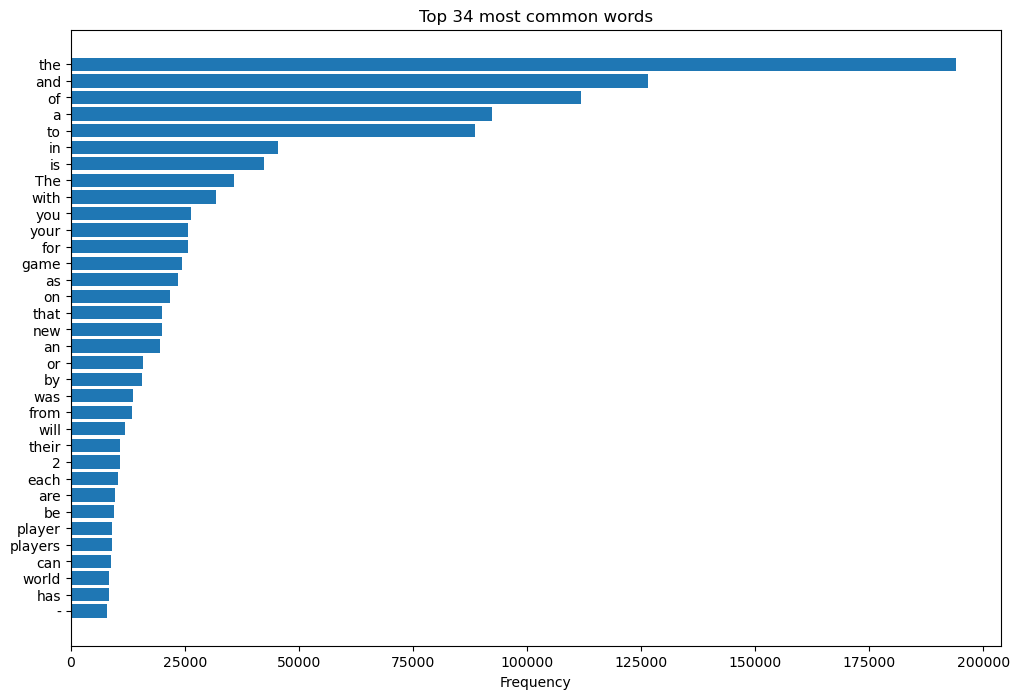

[('the', 194115), ('and', 126423), ('of', 111804), ('a', 92324), ('to', 88663), ('in', 45386), ('is', 42414), ('The', 35760), ('with', 31886), ('you', 26334), ('your', 25704), ('for', 25690), ('game', 24435), ('as', 23594), ('on', 21690), ('that', 20007), ('new', 19961), ('an', 19568), ('or', 15808), ('by', 15648), ('was', 13559), ('from', 13332), ('will', 11883), ('their', 10812), ('2', 10802), ('each', 10463), ('are', 9703), ('be', 9419), ('player', 9051), ('players', 8949), ('can', 8776), ('world', 8480), ('has', 8421), ('-', 8056)]


In [11]:
from collections import Counter
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

stopwords_list = list(ENGLISH_STOP_WORDS)
# Analyze most common words
text_data = df['description'].dropna().tolist()
words = [word for doc in text_data for word in doc.split()]
word_freq = Counter(words)

# Plot the most common words
common_words = word_freq.most_common(34)
words, counts = zip(*common_words)
plt.figure(figsize=(12, 8))
plt.barh(words, counts)
plt.xlabel('Frequency')
plt.title('Top 34 most common words')
plt.gca().invert_yaxis()
plt.show()

print(common_words)

In [12]:
most_common_words = [word for word, count in common_words]
stopwords_list.extend(most_common_words)
stopwords_list

['how',
 'once',
 'they',
 'nobody',
 'along',
 'very',
 'from',
 'been',
 'no',
 'himself',
 'thence',
 'or',
 'that',
 'nor',
 'our',
 'indeed',
 'across',
 'up',
 'front',
 'its',
 'go',
 'over',
 'often',
 'yourselves',
 'moreover',
 'something',
 'was',
 'the',
 'everywhere',
 'of',
 'any',
 'couldnt',
 'why',
 'nevertheless',
 'always',
 'besides',
 'around',
 'already',
 'out',
 'therefore',
 'to',
 'cannot',
 'co',
 'are',
 'keep',
 'get',
 'beyond',
 'four',
 'please',
 'six',
 'somehow',
 'not',
 'well',
 'hereupon',
 'whither',
 'cant',
 'do',
 'system',
 'part',
 'this',
 'onto',
 'whereby',
 'now',
 'if',
 'wherever',
 'three',
 'his',
 'he',
 'could',
 'elsewhere',
 'everything',
 'among',
 'down',
 'hasnt',
 'eleven',
 'when',
 'beforehand',
 'call',
 'whenever',
 'sometimes',
 'seems',
 'further',
 'itself',
 'their',
 'several',
 'hence',
 'it',
 'has',
 'have',
 'throughout',
 'some',
 'eg',
 'former',
 'serious',
 'behind',
 'than',
 'see',
 'however',
 'became',
 'w

In [13]:
#Trains a model whose vectors size is 5000, composed by the main unigrams and bigrams found in the corpus, ignoring stopwords
vectorizer = TfidfVectorizer(analyzer='word',
                     ngram_range=(1, 2), # potential use of unigrams and bigrams as feature
                     min_df=0.003, # start from 0.03% of freq word appear
                     max_df=0.9, # 90% and above common words are ignored
                     max_features=5000, # retaining only 5000 words as feature
                     stop_words=stopwords_list) # ignoring stopwords and most common words that don't help

item_ids = df['Game-id'].tolist()
tfidf_matrix = vectorizer.fit_transform(df['description']+df['Game-title'])
tfidf_feature_names = vectorizer.get_feature_names_out()
tfidf_matrix

<42246x4710 sparse matrix of type '<class 'numpy.float64'>'
	with 2163335 stored elements in Compressed Sparse Row format>

In [14]:
def get_item_profile(item_id):
    idx = item_ids.index(item_id)
    item_profile = tfidf_matrix[idx:idx+1]
    return item_profile

def get_item_profiles(ids):
    item_profiles_list = [get_item_profile(x) for x in ids]
    item_profiles = scipy.sparse.vstack(item_profiles_list)
    return item_profiles

def build_users_profile(person_id, interactions_indexed_df):
    interactions_person_df = interactions_indexed_df.loc[person_id]
    user_item_profiles = get_item_profiles(interactions_person_df['Game-id'])
    
    user_item_strengths = np.array(interactions_person_df['personal-rating']).reshape(-1, 1)
    
    # Weighted average of item profiles by the interactions strength
    user_item_strengths_weighted_avg = np.sum(user_item_profiles.multiply(user_item_strengths), axis=0) / np.sum(user_item_strengths)
    
    # Convert to numpy array and ensure 2D shape
    user_item_strengths_weighted_avg = np.asarray(user_item_strengths_weighted_avg).reshape(1, -1)
    
    # Normalize
    user_profile_norm = sklearn.preprocessing.normalize(user_item_strengths_weighted_avg)
    
    return user_profile_norm

def build_users_profiles(): 
    interactions_indexed_df = interactions_train_df[interactions_train_df['Game-id'] \
                                                   .isin(df['Game-id'])].set_index('User-id')
    user_profiles = {}
    for person_id in interactions_indexed_df.index.unique():
        user_profiles[person_id] = build_users_profile(person_id, interactions_indexed_df)
    return user_profiles

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=DeprecationWarning)
    user_profiles = build_users_profiles()

In [15]:
import warnings

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=DeprecationWarning)
    
user_profiles = build_users_profiles()
len(user_profiles)

1717

In [16]:
user_game_counts = df.groupby('User-id')['Game-id'].count().reset_index()
user_game_counts.columns = ['User-id', 'Game-title-count']

print(user_game_counts.head())


max_games_user = user_game_counts.loc[user_game_counts['Game-title-count'].idxmax()]
print("User with the most game titles:")
print(max_games_user)

   User-id  Game-title-count
0     5250                 4
1    76767                12
2    86540                 7
3   229911                 7
4   298950                94
User with the most game titles:
User-id             62990992
Game-title-count         304
Name: 1212, dtype: int64


In [17]:
myprofile = user_profiles[62990992]
print(myprofile.shape)
pd.DataFrame(sorted(zip(tfidf_feature_names, 
                        user_profiles[62990992].flatten().tolist()), key=lambda x: -x[1])[:20],
             columns=['token', 'relevance'])

(1, 4710)


,token,relevance
0,war,0.139865
1,games,0.119543
2,rpg,0.114059
3,action,0.110475
4,battle,0.107987
5,space,0.107163
6,quest,0.105333
7,enemies,0.102379
8,way,0.098667
9,evil,0.098211


# Content-Based Recommender Class

In [18]:
class ContentBasedRecommender:
    
    MODEL_NAME = 'Content-Based'
    
    def __init__(self, items_df=None):
        self.item_ids = item_ids
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
    
    def getUniqueList(self,similar_items):
        # Retaining only unique sets of item
        seen = set()
        unique_similar_items = []
        for item in similar_items:
            if item not in seen:
                unique_similar_items.append(item)
                seen.add(item)
                
        return unique_similar_items
    
    def _get_similar_items_to_user_profile(self, person_id, topn=1000):
        if person_id not in user_profiles:
            return []
        # Computes the cosine similarity between the user profile and all item profiles
        user_profile = user_profiles[person_id]
        cosine_similarities = cosine_similarity(user_profile, tfidf_matrix)
        # Gets the top similar items
        similar_indices = cosine_similarities.argsort().flatten()[-topn:]
        # Sort the similar items by similarity
        similar_items = sorted([(self.item_ids[i], cosine_similarities[0, i]) for i in similar_indices], \
                               key=lambda x: -x[1])
        
        similar_items = self.getUniqueList(similar_items)
        return similar_items
        
    def recommend_items(self, user_id, items_to_ignore=[], topn=1000000000, verbose=False, metric=0):
        similar_items = self._get_similar_items_to_user_profile(user_id)
        
        # Local model recommendation use
        if(metric!=1):
            items_to_ignore = df[df['User-id'] == user_id]['Game-id'].tolist()
            
        #Ignores items the user has already interacted
        similar_items_filtered = list(filter(lambda x: x[0] not in items_to_ignore, similar_items))
        
        recommendations_df = pd.DataFrame(similar_items_filtered, columns=['Game-id', 'recStrength']) \
                                    .head(topn)
        
        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')
                

            unique_items_df = self.items_df.drop_duplicates(subset='Game-id')

            recommendations_df = recommendations_df.merge(unique_items_df, how = 'left', 
                                                          left_on = 'Game-id', 
                                                          right_on = 'Game-id')[['recStrength', \
                                                                                   'Game-id', \
                                                                                   'Game-title', \
                                                                                   'Genre', \
                                                                                   'description']]

            
        return recommendations_df
    
content_based_recommender_model = ContentBasedRecommender(df)

# Evaluating model

## Precision

In [19]:
import warnings

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=DeprecationWarning)

print('Evaluating Content-Based Filtering model...')
cb_global_metrics, cb_detailed_results_df = model_evaluator.evaluate_model(content_based_recommender_model)
print('\nGlobal metrics:\n%s' % cb_global_metrics)
cb_detailed_results_df.head(10)

Evaluating Content-Based Filtering model...


C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample

C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
C:\Users\Mackhem\AppData\Local\Temp\ipykernel_33736\282107622.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  non_interacted_items_sample

1716 users processed

Global metrics:
{'modelName': 'Content-Based', 'recall@5': 0.035807591824189335, 'recall@10': 0.036883356385431075}


,hits@5_count,hits@10_count,interacted_count,recall@5,recall@10,UserID
106,2,8,61,0.032787,0.131148,62990992
63,2,2,49,0.040816,0.040816,138941587
133,1,1,36,0.027778,0.027778,11403772
50,2,2,35,0.057143,0.057143,49893565
33,0,0,35,0.000000,0.000000,48798067
45,5,5,34,0.147059,0.147059,24469287
31,2,2,32,0.062500,0.062500,116876958
149,3,3,30,0.100000,0.100000,47457723
109,2,2,29,0.068966,0.068966,11373749
119,1,1,27,0.037037,0.037037,10599862


In [20]:
def inspect_interactions(person_id, test_set=True):
    if test_set:
        interactions_df = interactions_test_indexed_df.sort_values(by='personal-rating', ascending=False)
    else:
        interactions_df = interactions_train_indexed_df.sort_values(by='personal-rating', ascending=False)
    return interactions_df.loc[person_id]

In [21]:
inspect_interactions(11403772, test_set=False).head(10)

,Game-id,Game-title,Genre,personal-rating,description
User-id,,,,,
11403772,1244,Ironclad Tactics,Real Time Strategy (RTS),5,"Ironclad Tactics is a fast-paced, card-based t..."
11403772,983,Freedom Planet,Platform,5,Freedom Planet is a combat-based platform adve...
11403772,2334,Team Fortress 2,Shooter,5,The WAR! Update was a class update for the Dem...
11403772,470,Coffin Dodgers,Racing,5,Coffin Dodgers sees you take on the role of sa...
11403772,1980,SUPER DISTRO,Adventure,5,"""Super Distro"" is a hard-as-nails 2D platforme..."
11403772,1138,Hard Reset,Shooter,5,The acclaimed First-Person Shooter returns ful...
11403772,1424,Magic Duels,Strategy,5,Join tens of millions of Magic: The Gathering ...
11403772,2046,Shadow Warrior Classic Redux,Shooter,5,The definitive version of the cult classic sho...
11403772,1829,RAGE,Shooter,5,Rage is a first-person shooter set in the not-...


In [22]:
content_based_recommender_model.recommend_items(11403772, topn=10, verbose=True)

,recStrength,Game-id,Game-title,Genre,description
0,0.238766,2617,Unreal Tournament 2004,Shooter,Unreal Tournament 2004 is a multiplayer first ...
1,0.233623,69,Age of Wonders,Role-playing (RPG),"Age of Wonders III, like the previous games in..."
2,0.232685,71,Age of Wonders III,Role-playing (RPG),"Age of Wonders III, like the previous games in..."
3,0.227931,2080,SiN Episodes Emergence,Shooter,"You are John Blade, commander of HardCorps, an..."
4,0.227787,479,Command and Conquer 3 Tiberium Wars,Real Time Strategy (RTS),"MultiplayerNote: As of June 2014, our friends ..."
5,0.225521,2281,Super Panda Adventures,Platform,"In Super Panda Adventures, you play as the bra..."
6,0.223668,1048,God Mode,Shooter,Do you like running? How about gunning? What i...
7,0.223127,552,Cubemen 2,Shooter,"Cubemen 2 is a fast paced, action packed, orig..."
8,0.220335,685,Distance,Racing,Distance is a survival racing game that combin...
9,0.219821,2665,War Inc. Battlezone,Shooter,War Inc. Battle Zone delivers hard hitting act...


In [23]:
def gather_scores_and_labels(model, test_data, item_ids):
    y_true = []
    y_scores = []

    # Iterate through each user in the test set
    for user_id in test_data['User-id'].unique():
        # Actual interactions from test data
        actual_interactions = set(test_data[test_data['User-id'] == user_id]['Game-id'])
        
        # Predict scores for all items using the recommender model
        predicted_scores = model.recommend_items(user_id, topn=len(item_ids), verbose=False)
        
        # Create a dataframe for merging true labels and predicted scores
        all_items_df = pd.DataFrame(item_ids, columns=['Game-id'])
        all_items_df = all_items_df.merge(predicted_scores, on='Game-id', how='left').fillna(0)
        
        # True labels: 1 if item was interacted with, 0 otherwise
        all_items_df['true_label'] = all_items_df['Game-id'].apply(lambda x: 1 if x in actual_interactions else 0)
        
        y_true.extend(all_items_df['true_label'])
        y_scores.extend(all_items_df['recStrength'])

    return y_true, y_scores

In [24]:
item_ids = df['Game-id'].unique()  # Extracting all game IDs from the items dataframe
y_true, y_scores = gather_scores_and_labels(content_based_recommender_model, interactions_test_df, item_ids)

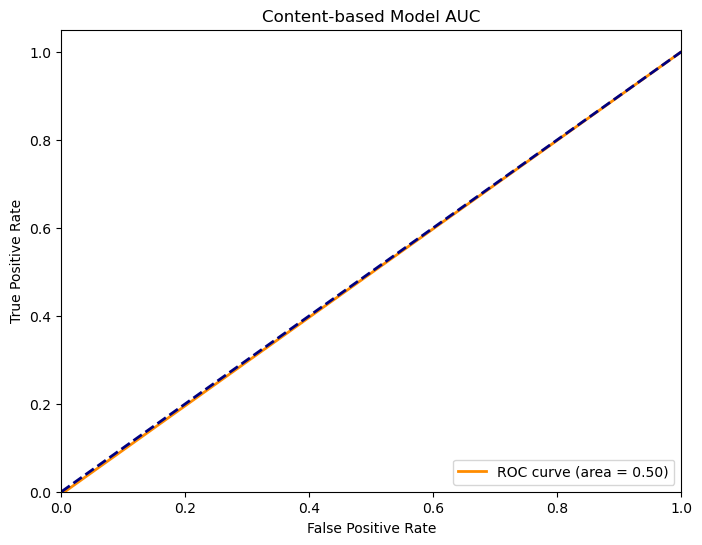

In [25]:
# Calculate ROC curve and AUC
fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Content-based Model AUC')
plt.legend(loc="lower right")
plt.show()